In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")
include("Lagrange_Mat.jl")

Lagrange_Mat (generic function with 1 method)

# Advection Equation

\begin{align}
  \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x}, &= 0,
  \quad x\in[0,1], \quad t\in(0,T],\\
  u(t,0) &= u(t,1)=0, \quad u(0,x) = exp(-200*(x-0.25)^2).
\end{align}

Discretizing by implicit Upwind gives

\begin{align*}
  \frac{u^{n+1}_i - u^{n}_i}{\Delta t} = -c
  \frac{u^{n+1}_{i} - u^{n+1}_{i-1}}{\Delta x}
\end{align*}

In [4]:
# Solving the heat equation (Implicit Upwind)
function predictor(dx, dt, un)
    # un: takes the initial condtion
    n = length(un)
    c= 1.0
    alpha = (c*dt) /dx # CFL condition
    #A = Array(Tridiagonal(fill(alpha, n-1), fill(1, n), fill(-alpha, n-1)))
     A = Array(Tridiagonal(fill(-alpha, n-1),fill(1 .+ alpha, n),fill(0.0, n-1)))
    f=un 
    return A\f
end

predictor (generic function with 1 method)

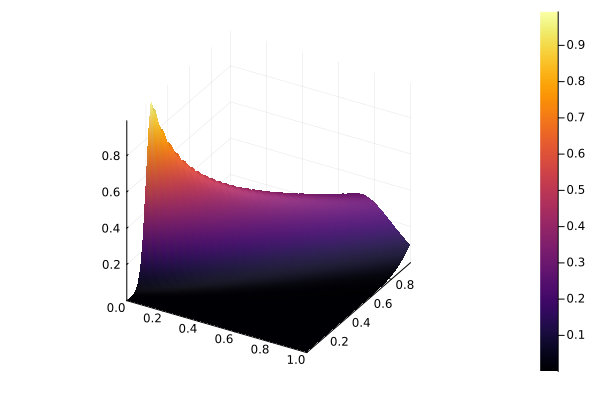

In [5]:

N = 100 # number of time intervals
M = 40 # number of (interior) spatial grid points

tspan = [0 1.0]
dt = (tspan[2] - tspan[1])/N
dx = 1.0/(M+1)
x = (1:M) .* dx
t = (0:N) .* dt
c=1.0

u0 = exp.(-200*(x .- 0.25).^2)

exact = [exp.(-200 .* (x .- 0.25 .- c * t[n]) .^2 ) for n in 1:length(t)]

u = zeros(M, N+1)
u[:,1] = u0

for n = 1:N
    u[:,n+1] = predictor(dx, dt, u[:,n])
end

#surface(t, x, u, xlabel="t",ylabel="x")

surface(t, x, u)

convergence order = 0.9088007607423295

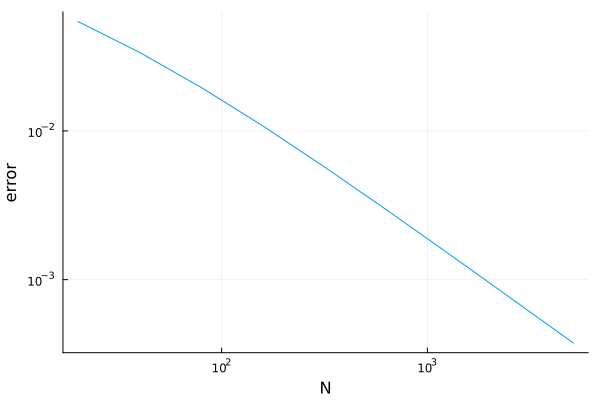

In [6]:
# First-order Correction for IMEX (predictor)

# Convergence Study in time

M = 80  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (M + 1)
x = (1:M) .* dx
u0 = x .* (1 .- x)

K = 10
err = zeros(K-1, 1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_final = zeros(M, K)

for k in 1:K
    N =  10* 2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    u = copy(u0)
    for n in 1:N
        u = predictor(dx, dt, u)
    end
    
    # Store only the final state for each k
    u_final[:, k] = copy(u)
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_final[:, k] - u_final[:, k-1])
    nstore[k-1] =  10*2^(k-1)  # Store N values for analysis
end

# Polyfit
p = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(p[2]))

plot(nstore,err,xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",legend=false)

FTCS Predictor and One RIDC correction

In [8]:
# Define the right-hand side of the function Du

function rs(u,dx)
    # approximates D u
    n = length(u)
    c=1.0
    alpha= c / dx
    D = Array(Tridiagonal(fill(alpha, n-1), fill(-alpha, n),fill(0.0,n-1)))
    
    return D*u
end

rs (generic function with 1 method)

In [10]:
# RIDC2 with IMEX correction

function RIDC2(N, tspan, u0, dx, dt)
    M=length(u0)
    #dt=(tspan[2]-tspan[1])/N
    t=(0:N)*dt
    u=zeros(M, N+1, 2)
    u[:, 1, 1]=u0
    u[:, 1, 2]=u0

    c=1.0 # speed
    alpha = (c*dt)/dx # CFL number
    A = Array(Tridiagonal(fill(-alpha, M-1),fill(1 .+ alpha, M),fill(0.0, M-1)))

    # Predictor (FTCS)
    for n=1:N
        f = u[:, n, 1]  # Right-hand side for the predictor
        u[:, n+1, 1] = A \ f  # Implicit solve for the predictor
    end

    # One correction RIDC2 (Implicit)
    for n=1:N
        
        rs_n = rs(u[:, n, 1], dx)      # 
        rs_n1 = rs(u[:, n+1, 1], dx)   # 

        # Perform Lagrange interpolation
        rs_values = hcat(rs_n, rs_n1)  
        quad_approx = Lagrange_Mat(t[n:n+1], rs_values, t[n], t[n+1])

        f = u[:, n, 2] .- dt .* rs(u[:, n+1, 1], dx) .+ quad_approx
        u[:, n+1, 2] = A \ f
    end
    
    return u
end

RIDC2 (generic function with 1 method)

convergence order = 0.8967703136336921
convergence order = 1.873039139695735


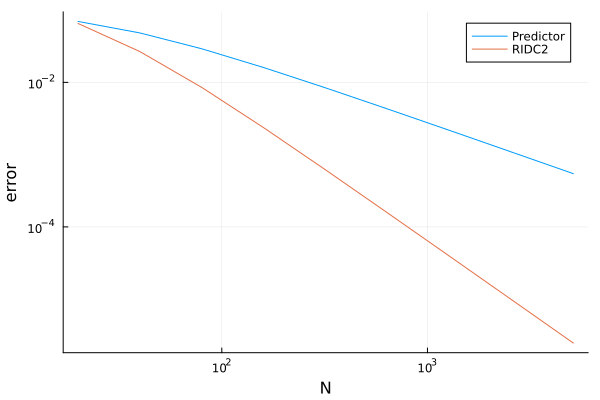

In [12]:
# Convergence Study in time

X = 40  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0=exp.(-200*(x .- 0.25).^2)

K = 10
err = zeros(K-1, 2)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K, 2)

for k in 1:K
    
    N = 10*2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =RIDC2(N, tspan, u0, dx, dt)

    
    # Store only the final state for each k
    u_store[:, k, 1]=u[:, end, 1]
    u_store[:, k, 2] = u[:, end, 2]
end

# Calculate errors
for k in 2:K
    err[k-1, 1] = norm(u_store[:, k, 1] - u_store[:, k-1, 1]) .+ 10^(-16)
    err[k-1, 2] = norm(u_store[:, k, 2] - u_store[:, k-1, 2]) .+ 10^(-16)
    nstore[k-1] = 10*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:, 1],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Predictor")
pdeg = polyfit(log10.(nstore[:]),log10.(err[:, 2]),1)
print("convergence order = ",abs(pdeg[2]), "\n")
plot!(nstore,err[:, 2],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="RIDC2")
display(plot!(legend=:topright))

Two-Level Deferred Correction for the advection equation

In [18]:
# Reference Solution
function Ref(tspan, u0, dx, dt, N)
    
    M=length(u0)
    m=2 # Coarsenning factor
    t=(0:N)*dt
    DT=m*dt
    U=zeros(M, N+1, 2)
    
    U[:, 1, 1]=u0
    U[:, 1, 2]=u0

    c=1.0

    alpha = (c*dt) /dx # CFL condition
    
    A = Array(Tridiagonal(fill(-alpha, M-1),fill(1 .+ alpha, M),fill(0.0, M-1)))

    for i=1:m:N
        U[:, i, 1]=U[:, i, 2]

        # F-Relaxation
        for j=i:i+1
            U[:, j+1, 1]= A \ U[:, j, 1]
        end

        # Coarse Correction


        # Right-hand-side function value
        rs_n = rs(U[:, i, 1], dx)      
        rs_n1 = rs(U[:, i+1, 1], dx) 
        rs_n2 = rs(U[:, i+2, 1], dx) 

        # Perform Lagrange interpolation 
        rs_values = hcat(rs_n, rs_n1, rs_n2)  # Matrix of residuals (M, 3)
        
        quad_approx = Lagrange_Mat(t[i:i+2], rs_values, t[i], t[i+2])

        
        # Assemble the right-hand side for the correction
        f = U[:, i, 2] .- DT .* rs(U[:, i+m, 1], dx) .+ quad_approx # Right-hand side RIDC for ut=uxx
        # Needs to redefine Matrix A for the coarse system 
        c = 1.0
        alpha1 = c * (DT / dx) # DT
        B = Array(Tridiagonal(fill(-alpha1, M-1),fill(1 .+ alpha1, M),fill(0.0, M-1)))
        U[:, i+m, 2] = B \ f
    end
    return U
end

Ref (generic function with 1 method)

convergence order = 1.9422035190308296


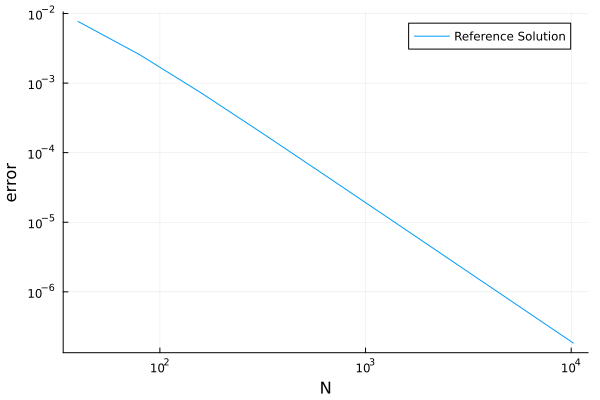

In [20]:
# Convergence Study in time for the two-level Reference Solution

X = 80  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = x .*(1 .- x)

K = 10
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 20* 2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =Ref(tspan, u0, dx, dt, N)

    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, 2]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1])
    nstore[k-1] = 20*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Reference Solution")

In [28]:
function twolevel(tspan, u0, dx, dt, N, K)
    
    M=length(u0)
    m=2 # Coarsenning factor
    DT=m*dt
    t=(0:N)*dt
    u=zeros(M, N+1, K+1)
    u[:, 1, 1]=u0
    ps=3:m:N
    u[:, ps, 1]= rand(M, length(ps))
    up=zeros(M, N+1)
    up[:, 1]=u0
    
    # Set up of Matrix A for the fine mesh
    c=1.0
    alpha = (c*dt) /dx # CFL condition
    
    A = Array(Tridiagonal(fill(-alpha, M-1),fill(1 .+ alpha, M),fill(0.0, M-1)))

    
    for k in 1:K

        u[:, 1, k+1]=u0

        # F-relaxation
        for i=1:m:N
            up[:, i]=u[:, i, k] # injection from the second level
            up[:, i+1]= A\up[:, i]
        end

        # C-relaxation
        for j=2:m:N
            up[:, j+1]=A\up[:, j]
        end

        # Coarse Grid Correction

        for n=1:m:N

            up[:, n]=  u[:, n, k]


            rs_n = rs(up[:, n], dx)      
            rs_n1 = rs(up[:, n+1], dx) 
            rs_n2 = rs(up[:, n+2], dx) 

            # Perform Lagrange interpolation using the residuals
            rs_values = hcat(rs_n, rs_n1, rs_n2)  # Matrix (M, 3)
        
            quad_approx = Lagrange_Mat(t[n:n+2], rs_values, t[n], t[n+2])


            # Assemble the right-hand side for the correction
            f = u[:, n, k+1] .- DT .* rs(up[:, n+m], dx) .+ quad_approx # Right-hand side RIDC
            
            # Needs to redefine Matrix A for the coarse system 
            c = 1.0
            alpha1 = c * (DT / dx) # CFL
            B = Array(Tridiagonal(fill(-alpha1, M-1),fill(1 .+ alpha1, M),fill(0.0, M-1)))
            u[:, n+m, k+1] = B \ f   
        end
    end
    return u
    
end

twolevel (generic function with 1 method)

convergence order = 1.9422035190662212


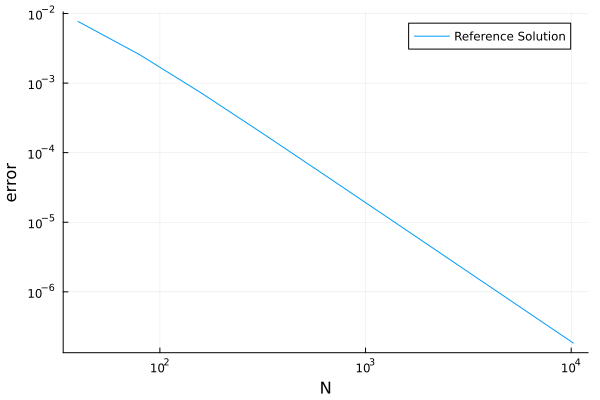

In [30]:
# Convergence Study in time for the two-level Reference Solution

X = 80  # number of (interior) spatial grid points
tspan = [0 1.0]
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = x .*(1 .- x)

K = 10
err = zeros(K-1)  # we will compare successive solutions
nstore = zeros(K-1, 1)
u_store = zeros(X, K)

for k in 1:K
    
    N = 20* 2^k  # number of time intervals
    #nstore[k]= N
    dt = (tspan[2] - tspan[1]) / N
    
    u =twolevel(tspan, u0, dx, dt, N, 30)
    
    
    # Store only the final state for each k
    u_store[:, k] = u[:, end, end]
end

# Calculate errors
for k in 2:K
    err[k-1] = norm(u_store[:, k] - u_store[:, k-1])
    nstore[k-1] = 20*2^(k-1)  # Store N values for analysis
end

# Polyfit
pdeg = polyfit(log10.(nstore[:]),log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]), "\n")

plot(nstore,err[:],xaxis=:log,yaxis=:log,xlabel="N",ylabel="error",label="Reference Solution")

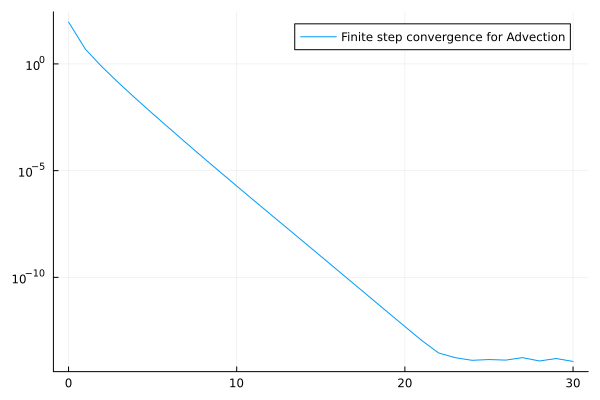

In [32]:
# Convergence Study in time for the two-level Reference Solution

X = 100   # number of (interior) spatial grid points
dx = 1.0 / (X + 1)
x = (1:X) .* dx
u0 = exp.(-200*(x .- 0.25).^2)
m=2
tspan = [0 1.0]
N=600
dt=(tspan[2]-tspan[1])/N
K=30
err=zeros(K+1)
U=Ref(tspan, u0, dx, dt, N)
u=twolevel(tspan, u0, dx, dt, N, K)
for k=1:K+1
    err[k] = norm(U[:, 1:m:end, 2] .- u[:, 1:m:end, k]) .+10^(-16)
end
plot(0:K, err, yaxis=:log, label="Finite step convergence for Advection")